### Purpose:
Classify users as 'adopted user' based on definition (a user that has logged into the platform on 3 separate days within a 7-day period) and identiy factors that predict future user adoption.

### Exploratory Data Analysis
**Result:**
- Created column 'adopted_user' by referencing login table
    - 13.8% (1656/12000) of users are adopted users
- 'creation_source' does trend with probability of adopted user (GUEST_INVITE and SIGNUP_GOOGLE_AUTH positively trend with adopted user, PERSONAL_PROJECTS negatively trends)
- Created column 'invited_by_user'
- 'invited_by_user' weakly trends with adopted user. Users that were invited by pre-existing user more likely to become an adopted user
    - Is redundant with GUEST_INVITE
        - When users['invited_by_user'] == 1, users['creation_source'] = [GUEST_INVITE, ORG_INVITE]
        - When users['invited_by_user'] == 0, users['creation_source'] = [SIGNUP, SIGNUP_GOOGLE_AUTH, PERSONAL_PROJECTS]
- 'opted_in_to_mailing_list' and 'enabled_for_marketing_drip' do not trend with 'adopted_user'
- Not sure what to do with 'last_session_creation_time'
- Will further processing 'org_id' and 'invited_by_user_id' to create additional features in preprocessing stage

**Data:**
Two tables
- 'takehome_user_engagement.csv'
    - 207917 rows
    - 3 columns:
        - time_stamp (str, MM/DD/YYYY HH:MM)
        - user_id (int): primary key, connects to 'object_id' of 'takehome_users.csv'
        - visited (bool): If 0, then error
- 'takehome_users.csv'
    - 12000 rows
    - 10 columns:
        - object_id (int): primary key, connects to user_id of 'takehome_user_engagment.csv' 
        - creation_time (str, MM/DD/YYYY): time at which account was created
        - name (str): name of user
        - email (str): email address
        - creation_source (str, category): how account was created, takes on one of 5 values
            - PERSONAL_PROJECTS: invited to join another user's personal workspace
            - GUEST_INVITE: invited to an organization as a guest (limited permissions)
            - ORG_INVITE: invited to an an organization (as a full member)
            - SIGNUP: signed up via website
            - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication
        - last_session_creation_time (int, unix timestamp): timestamp of last login
        - opted_in_to_mailing_list (bool): whether user opted in into receiving marketing emails
        - enabled_for_marketing_drip (bool): whether user is on the regular marketing drip
        - org_id (int): the organization they belong to
        - invited_by_user_id (int): which user intied them to join, if applicable

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='cp1252')
logins = pd.read_csv('takehome_user_engagement.csv', encoding='cp1252')

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [5]:
def boolAdoptedUser(user_id: int, logins: pd.DataFrame) -> bool:
    '''
    Determines if user can be classified as an 'adopted user' (a user that has logged into the platform on 3 separate days within a 7-day period)
    Inputs:
        user_id (int)
        logins (pandas DataFrame)
    '''
    login_user = logins[logins['user_id'] == user_id]
    if len(login_user) < 3:
        return 0
    
    first_login = pd.Timestamp(min(login_user['time_stamp']))
    login_intervals = [(pd.Timestamp(i) - first_login).round(freq='d').days for i in login_user['time_stamp']]
    
    for i in range(len(login_intervals)-2):
        if login_intervals[i+2] - login_intervals[i] <= 7:
            return 1
    return 0

In [6]:
users['adopted_user'] = [boolAdoptedUser(i, logins) for i in users['object_id']]

In [7]:
users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0


In [8]:
print(users[users['adopted_user'] == 1].shape)

(1656, 11)


13.8% (1656/12000) users fit 'adopted user' definition. Classifying adopted vs non-adopted will be unbalanced

([0, 1, 2, 3, 4],
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

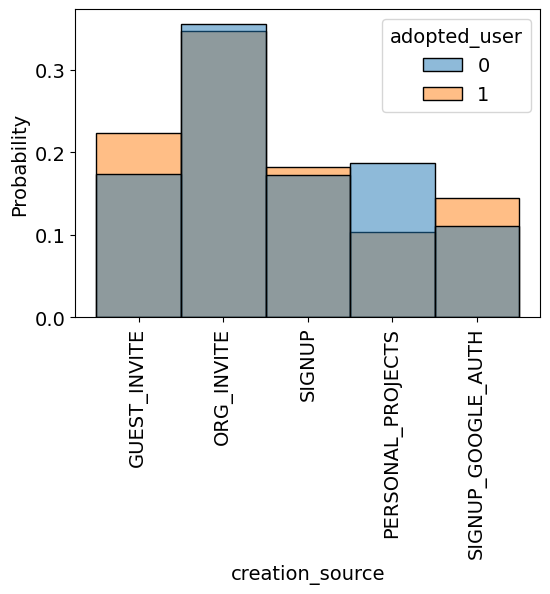

In [9]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
sns.histplot(data=users, x='creation_source', hue='adopted_user', stat='probability', common_norm=False)
plt.xticks(rotation=90)

Users that were invited by a guest or signed up with google auth are more likely to become adopted users. Users that signed up for personal projects are less likely

In [10]:
users['invited_by_user'] = [int(i) for i in users['invited_by_user_id'].notna()]

([<matplotlib.axis.XTick at 0x20aef34b550>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

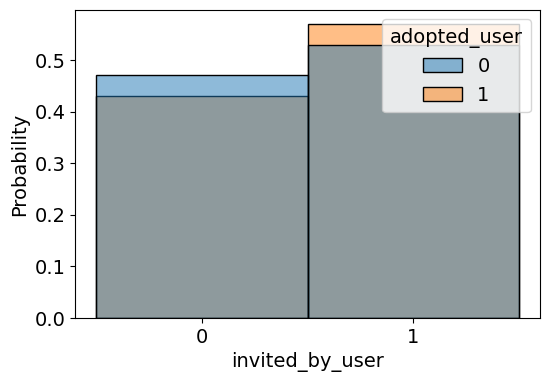

In [11]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
sns.histplot(data=users, x='invited_by_user', hue='adopted_user', stat='probability', common_norm=False, discrete=True)
plt.xticks([0, 1])

Users that were invited by another user are more likely to become adopted users

In [12]:
users[users['invited_by_user'] == 1]['creation_source'].value_counts()

ORG_INVITE      4254
GUEST_INVITE    2163
Name: creation_source, dtype: int64

In [13]:
users[users['invited_by_user'] == 0]['creation_source'].value_counts()

PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

([<matplotlib.axis.XTick at 0x20afb278c90>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

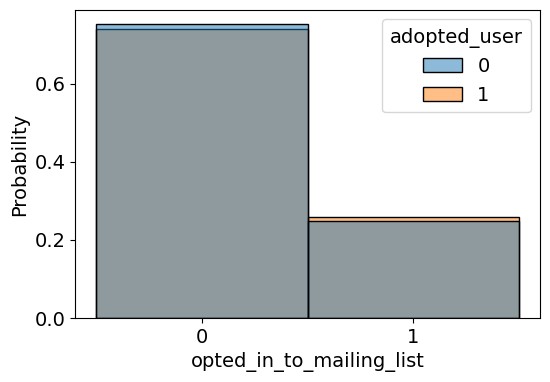

In [57]:
plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14})
sns.histplot(data=users, x='opted_in_to_mailing_list', hue='adopted_user', stat='probability', common_norm=False, discrete=True)
plt.xticks([0, 1])

No discernable difference in becoming an adopted user with respect to opting in for mailing list or enabling marketing drip

### Preprocessing
**Result:**
**Goals:** 
- Convert org_id to numerical data
    - Counted the number of users associated with the org
        - Histogram is approximately log-normal distributed, so converting to log(users_per_org)
- Convert invited_by_user_id to numerical data
    - Counted the number of users invited by inviter
    - Also added column for number of users invited (user_invites)
- Extract month of creation time
    - creation_time_month shows some trend with adopted_user with users signing up during months of April and May being less likely to become an adopted user, however, best not to think too hard about this trend as is not present for all years
- Extract day of week of creation time

In [16]:
users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_by_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1


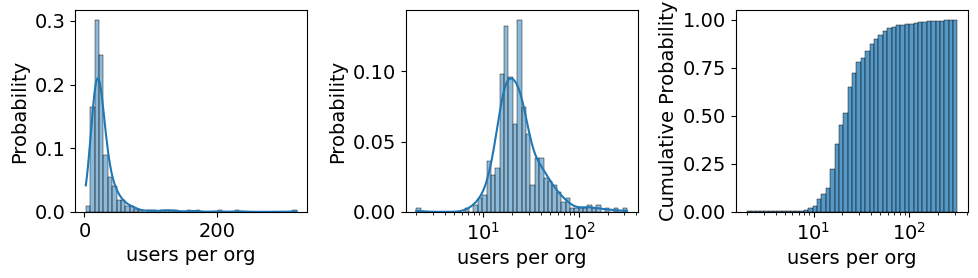

In [17]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
sns.histplot(users['org_id'].value_counts(), stat='probability', bins=48, kde=True)
plt.xlabel('users per org')
plt.subplot(1,3,2)
sns.histplot(users['org_id'].value_counts(), stat='probability', log_scale=True, bins=48, kde=True)
plt.xlabel('users per org')
plt.subplot(1,3,3)
ax = sns.histplot(users['org_id'].value_counts(), cumulative=True, stat='probability', log_scale=True, bins=48)
plt.xlabel('users per org')
plt.ylabel('Cumulative Probability')
plt.tight_layout()

Text(0.5, 0, 'log(users_per_org)')

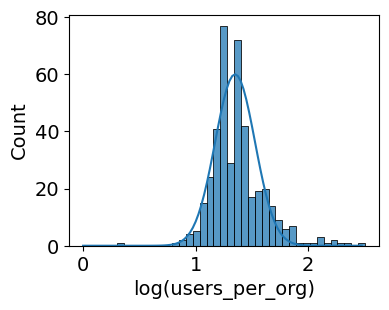

In [18]:
plt.figure(figsize=(4,3))
sns.histplot(np.log10(users['org_id'].value_counts()))
x = np.arange(0, 2.5, 0.025)
y = 60*np.exp(-(x-1.35)**2/0.0625)
plt.plot(x, y)
plt.xlabel('log(users_per_org)')

log(users_per_org) is approximately normally distributed with mean of 1.35 and std of roughly 0.35

In [19]:
def findPercentile(bins, ecdf, q, log_scale = True):
    for ind, val in enumerate(ecdf):
        if val > q:
            p = (bins[ind]+bins[ind+1])/2
            break
    if log_scale:
        return 10**p
    else:
        return p

In [20]:
counts, bins = np.histogram(np.log10(users['org_id'].value_counts()), bins=48)

cum_prob = []
my_sum = 0
for i in counts:
    my_sum += i
    cum_prob.append(my_sum)
cum_prob = np.array(cum_prob)/sum(counts)

print([findPercentile(bins, cum_prob, q) for q in [0.33, 0.66]])

[17.44987710057824, 26.629055522631713]


In [21]:
ind = users['org_id'].value_counts().index
val = users['org_id'].value_counts().to_list()
mapper = dict([(ind[i], val[i]) for i in range(len(val))])

mapper_size = dict()
for key, val in mapper.items():
    if val < 18:
        mapper_size[key] = 'small'
    elif val < 25:
        mapper_size[key] = 'medium'
    else:
        mapper_size[key] = 'large'

In [22]:
users['log(users_per_org)'] = [np.log10(mapper[i]) for i in users['org_id']]
users['org_size'] = [mapper_size[i] for i in users['org_id']]

In [23]:
key = users['invited_by_user_id'].value_counts().index
val = users['invited_by_user_id'].value_counts().to_list()
user_mapper = dict([(key[i], val[i]) for i in range(len(val))])

users['num_user_invites_of_inviter'] = [user_mapper[i] if pd.notna(i) else 0 for i in users['invited_by_user_id']]
users['num_user_invites'] = [user_mapper[i] if i in user_mapper.keys() else 0 for i in users['object_id']]

In [24]:
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['creation_time_month'] = users['creation_time'].dt.month
users['creation_time_dayofweek'] = users['creation_time'].dt.dayofweek

In [25]:
users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_by_user,log(users_per_org),org_size,num_user_invites_of_inviter,num_user_invites,creation_time_month,creation_time_dayofweek
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1,1.875061,large,1,0,4,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1,2.367356,large,3,0,11,4
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1,1.505150,large,11,1,3,1


In [26]:
plt.rcParams.update({'font.size': 10})

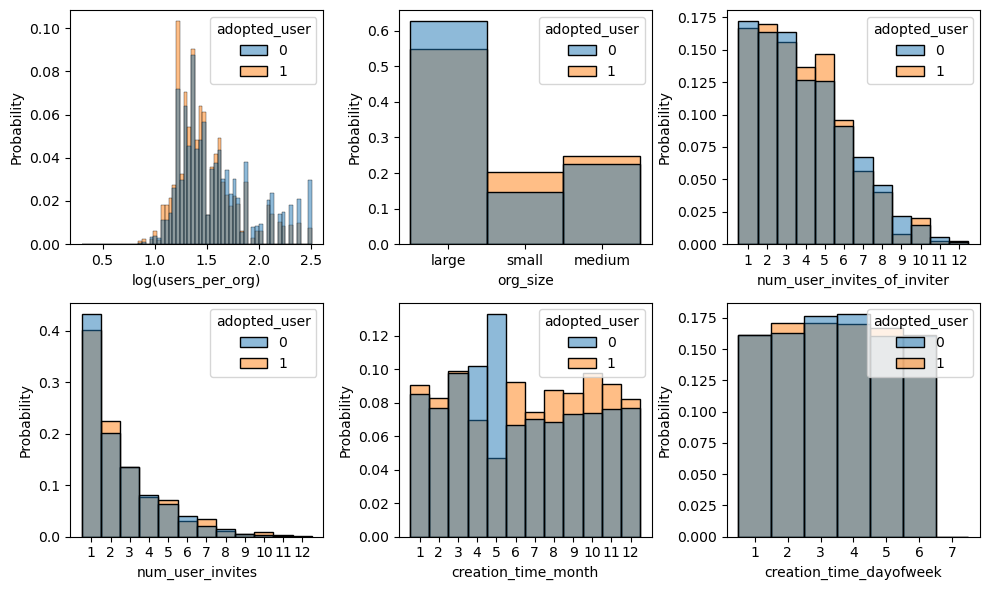

In [54]:
plt.figure(figsize=(10,6))
plt.subplot(2,3,1)
sns.histplot(data=users, x='log(users_per_org)', hue='adopted_user', common_norm=False, stat='probability')
plt.subplot(2,3,2)
sns.histplot(data=users, x='org_size', hue='adopted_user', common_norm=False, stat='probability')
plt.subplot(2,3,3)
sns.histplot(data=users, x='num_user_invites_of_inviter', hue='adopted_user', common_norm=False, stat='probability', bins=np.arange(0,13,1)+0.5)
plt.xticks(ticks=np.arange(1,13,1))
plt.subplot(2,3,4)
sns.histplot(data=users, x='num_user_invites', hue='adopted_user', common_norm=False, stat='probability', bins=np.arange(0,13,1)+0.5)
plt.xticks(ticks=np.arange(1,13,1))
plt.subplot(2,3,5)
sns.histplot(data=users, x='creation_time_month', hue='adopted_user', common_norm=False, stat='probability', bins=np.arange(0,13,1)+0.5)
plt.xticks(ticks=np.arange(1,13,1))
plt.subplot(2,3,6)
sns.histplot(data=users, x='creation_time_dayofweek', hue='adopted_user', common_norm=False, stat='probability', bins=np.arange(0,8,1)+0.5)
plt.xticks(ticks=np.arange(1,8,1))
plt.tight_layout()

In [28]:
users['creation_time_year'] = users['creation_time'].dt.year

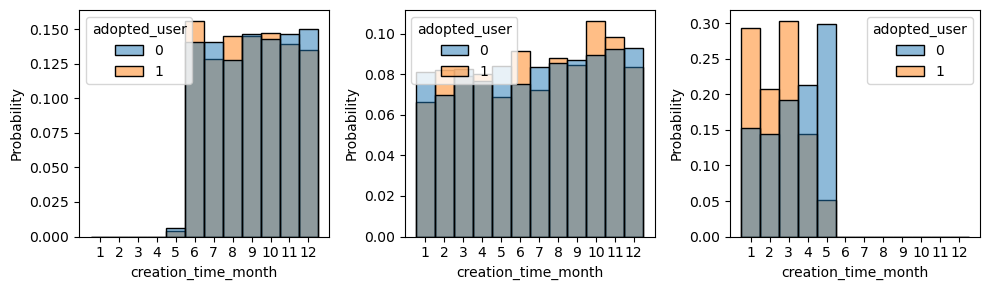

In [29]:
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
sns.histplot(data=users[users['creation_time_year']==2012], x='creation_time_month', hue='adopted_user', common_norm=False, stat='probability', bins=np.arange(0,13,1)+0.5)
plt.xticks(ticks=np.arange(1,13,1))
plt.subplot(1,3,2)
sns.histplot(data=users[users['creation_time_year']==2013], x='creation_time_month', hue='adopted_user', common_norm=False, stat='probability', bins=np.arange(0,13,1)+0.5)
plt.xticks(ticks=np.arange(1,13,1))
plt.subplot(1,3,3)
sns.histplot(data=users[users['creation_time_year']==2014], x='creation_time_month', hue='adopted_user', common_norm=False, stat='probability', bins=np.arange(0,13,1)+0.5)
plt.xticks(ticks=np.arange(1,13,1))
plt.tight_layout()

### Modeling
**Result:**
- Trained RandomForestClassifier
    - ```columns=['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user', 'creation_source', 'org_size', 'log(users_per_org)', 'num_user_invites_of_inviter', 'num_user_invites', 'creation_time_month', 'creation_time_dayofweek']```
    - ```class_weight='balanced', num_estimators=200, max_depth=5```
    - ```grid_params = {'n_estimators':[100, 150, 200, 250, 300], 'criterion':['gini', 'entropy', 'log_loss'], 'max_depth':[5, 10, 15, 20]}```
    - ```gridsearch_rf = GridSearchCV(rf_class, grid_params, scoring='precision', return_train_score=True, cv=5)```
    - Best estimator is ```RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200)```
        - TPR = 0.8975 (vs 0.8898 for random guess)
        - TNR = 0.2100 (vs 0.1380 for random guess)
        - specificity (recall of negative class) = 0.6078
    - 7 most important features in descending order:
        - log(users_per_org), creation_time_month, creation_source_PERSONAL_PROJECTS, num_user_invites, creation_time_dayofweek, num_user_invites_of_inviter, creation_source_SIGNUP_GOOGLE_AUTH
            - Size of org to which user belongs, creation source, number of invites sent by user, and the number of invites of by inviter are sensible features
            - creation time of both month and dayofweek are not very sensible and may arise from an anomaly in the data where we saw relatively more adopted users in the Jan-Mar of 2014 and relatively fewer adopted users in Apr and May of 2014.
    - 6 features, ```['creation_source_SIGNUP', 'org_size_medium', 'invited_by_user', 'enabled_for_marketing_drip', 'opted_in_to_mailing_list', 'creation_source_ORG_INVITE']``` were found to have low feature importances
        - Trained RandomForestClassifier with subset of features and both TPR and TNR dropped significantly. Although 6 features had low importance values, they positively contribute to model performance

In [30]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

In [31]:
class OneHotNan(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        ohe = OneHotEncoder(sparse_output=False)
        X_oh = ohe.fit_transform(X)
        
        if True not in pd.isnull(ohe.categories_):
            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
        if True in pd.isnull(ohe.categories_):
            for ind, val in enumerate(ohe.categories_[0]):
                if pd.isnull(val):
                    nan_col = ind
            nan_rows = [ind for ind, val in enumerate(X_oh[:, nan_col]) if val > 0]

            X_oh = pd.DataFrame(X_oh, columns=ohe.categories_[0])
            X_oh.loc[nan_rows,:] = pd.NA
            X_oh = X_oh.drop(columns=ohe.categories_[0][nan_col])
        return X_oh

class CategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        OH_NaN = OneHotNan()

        X_cat = pd.DataFrame()
        for cat_col in self.columns:
            df = OH_NaN.fit_transform(X[[cat_col]])

            new_cols = [cat_col+'_'+str(s) for s in df.columns]
            X_cat = pd.concat([X_cat, df.rename(columns=dict(zip(df.columns, new_cols)))], axis=1)
        return X_cat

class BinCategoricalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, Y=None):
        return self
    def transform(self, X):
        X_bin = pd.DataFrame()
        for col in self.columns:
            X_bin = pd.concat([X_bin, X[[col]].replace(('Y','N'), (1,0))], axis=1)
        return X_bin
    
class NumericalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

In [32]:
def preprocess(df):
    '''
    Preprocesses feature space using PCA to remove noise, knn_impute to remove nans, and standardscaler
    Do not feed in target space
    '''
    feature_union = FeatureUnion([
        ('bin_trans', BinCategoricalTransformer(columns=['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user'])),
        ('cat_trans', CategoricalTransformer(columns=['creation_source', 'org_size'])),
        ('num_trans', NumericalTransformer(columns=['log(users_per_org)', 'num_user_invites_of_inviter', 'num_user_invites', 'creation_time_month', 'creation_time_dayofweek']))
    ])
    impute_pipe = Pipeline([
        ('features', feature_union)
    ])

    df_imputed = impute_pipe.fit_transform(df)
    
    return df_imputed, impute_pipe

In [33]:
users.head(3)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,invited_by_user,log(users_per_org),org_size,num_user_invites_of_inviter,num_user_invites,creation_time_month,creation_time_dayofweek,creation_time_year
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,1,1.875061,large,1,0,4,1,2014
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,1,2.367356,large,3,0,11,4,2013
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,1,1.505150,large,11,1,3,1,2013


#### Larger feature space
```columns = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user', 'creation_source', 'org_size', 'log(users_per_org)', 'num_user_invites_of_inviter', 'num_user_invites', 'creation_time_month', 'creation_time_dayofweek']```

In [64]:
preprocess_users, preprocess_pipe = preprocess(users)
columns = np.append(preprocess_pipe['features']['bin_trans'].transform(users).columns, preprocess_pipe['features']['cat_trans'].transform(users).columns)
columns = np.append(columns, preprocess_pipe['features']['num_trans'].transform(users).columns)
preprocess_df = pd.DataFrame(preprocess_users, columns=columns)

X, Y = preprocess_df, users['adopted_user']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [65]:
X.head(3)

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_size_large,org_size_medium,org_size_small,log(users_per_org),num_user_invites_of_inviter,num_user_invites,creation_time_month,creation_time_dayofweek
0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.875061,1.0,0.0,4.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.367356,3.0,0.0,11.0,4.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.505150,11.0,1.0,3.0,1.0


##### Scoring='recall'

In [66]:
rf_class = RandomForestClassifier(class_weight='balanced')
grid_params = {'n_estimators':[100, 150, 200, 250, 300], 
               'criterion':['gini', 'entropy', 'log_loss'],
               'max_depth':[5, 10, 15, 20]}
gridsearch_rf = GridSearchCV(rf_class, grid_params, scoring='recall', return_train_score=True, cv=5)

In [67]:
# recall
gridsearch_rf.fit(x_train, y_train)
print(gridsearch_rf.best_estimator_)
print(gridsearch_rf.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=150)
0.5669172932330827


In [68]:
y_pred = gridsearch_rf.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1295  779]
 [ 150  176]]


In [69]:
sum(users['adopted_user'])/users.shape[0]

0.138

In [70]:
cm[1,1]/(cm[0,1] + cm[1,1])

0.18429319371727748

In [71]:
cm[0,0]/(cm[0,0] + cm[1,0])

0.8961937716262975

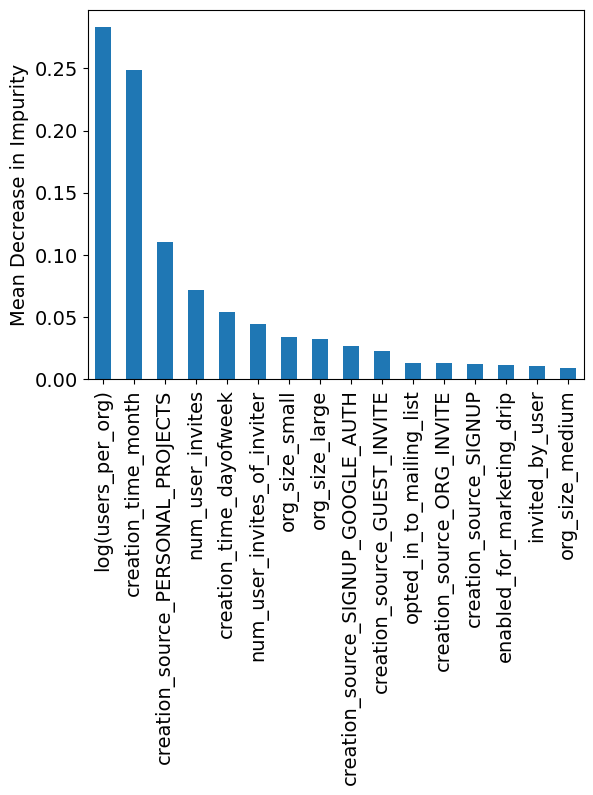

In [73]:
# recall
feature_importances = pd.Series(gridsearch_rf.best_estimator_.feature_importances_, index=columns).sort_values(ascending=False)
feature_importances.plot.bar()
plt.ylabel('Mean Decrease in Impurity');

##### Scoring='precision'

In [43]:
rf_class = RandomForestClassifier(class_weight='balanced')
grid_params = {'n_estimators':[100, 150, 200, 250, 300], 
               'criterion':['gini', 'entropy', 'log_loss'],
               'max_depth':[5, 10, 15, 20]}
gridsearch_rf = GridSearchCV(rf_class, grid_params, scoring='precision', return_train_score=True, cv=5)

In [44]:
# precision
gridsearch_rf.fit(x_train, y_train)
print(gridsearch_rf.best_estimator_)
print(gridsearch_rf.best_score_)

RandomForestClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=10, n_estimators=150)
0.21091937217129927


In [45]:
# precision
y_pred = gridsearch_rf.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(cm[1,1]/(cm[0,1] + cm[1,1]))
print(cm[0,0]/(cm[0,0] + cm[1,0]))

[[1648  417]
 [ 242   93]]
0.18235294117647058
0.8719576719576719


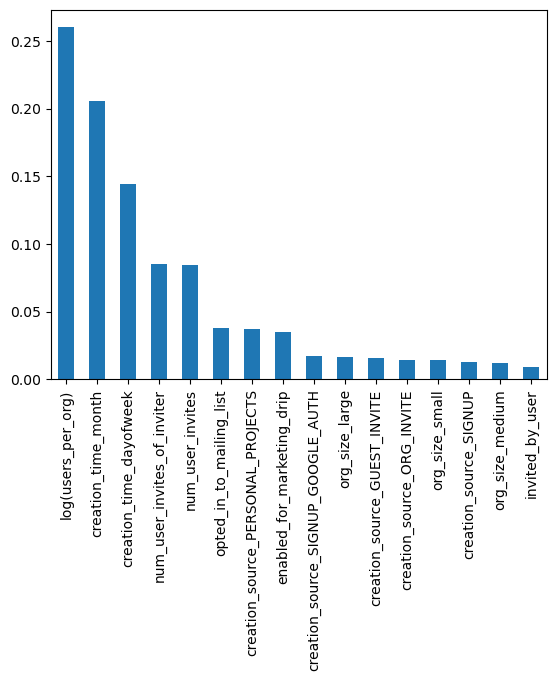

In [46]:
# precision
feature_importances = pd.Series(gridsearch_rf.best_estimator_.feature_importances_, index=columns).sort_values(ascending=False)
feature_importances.plot.bar();

#### Smaller feature space
```dropped_cols = ['creation_source_SIGNUP', 'org_size_medium', 'invited_by_user', 'enabled_for_marketing_drip', 'opted_in_to_mailing_list', 'creation_source_ORG_INVITE']```

In [47]:
# removing less important features (smaller feature importances)
X_subset = X.drop(columns=['creation_source_SIGNUP', 'org_size_medium', 'invited_by_user', 'enabled_for_marketing_drip', 'opted_in_to_mailing_list', 'creation_source_ORG_INVITE'])
X_subset.head(3)

,creation_source_GUEST_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP_GOOGLE_AUTH,org_size_large,org_size_small,log(users_per_org),num_user_invites_of_inviter,num_user_invites,creation_time_month,creation_time_dayofweek
0,1.0,0.0,0.0,1.0,0.0,1.875061,1.0,0.0,4.0,1.0
1,0.0,0.0,0.0,1.0,0.0,2.367356,3.0,0.0,11.0,4.0
2,0.0,0.0,0.0,1.0,0.0,1.505150,11.0,1.0,3.0,1.0


In [48]:
X_subset = X.drop(columns=['creation_source_SIGNUP', 'org_size_medium', 'invited_by_user', 'enabled_for_marketing_drip', 'opted_in_to_mailing_list', 'creation_source_ORG_INVITE'])
Y = users['adopted_user']
x_train, x_test, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2)

In [49]:
rf_class = RandomForestClassifier(class_weight='balanced')
grid_params = {'n_estimators':[150, 200, 250], 
               'criterion':['gini', 'entropy', 'log_loss'],
               'max_depth':[15, 20, 25]}
gridsearch_rf = GridSearchCV(rf_class, grid_params, scoring='precision', return_train_score=True, cv=5)

In [50]:
# precision
gridsearch_rf.fit(x_train, y_train)
print(gridsearch_rf.best_estimator_)
print(gridsearch_rf.best_score_)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=15, n_estimators=250)
0.1933262436488243


In [51]:
# precision
y_pred = gridsearch_rf.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(cm[1,1]/(cm[0,1] + cm[1,1]))
print(cm[0,0]/(cm[0,0] + cm[1,0]))

[[1927  125]
 [ 315   33]]
0.2088607594936709
0.85950044603033


In [52]:
columns_subset = np.delete(columns, [0, 1, 2, 4, 6, 9])

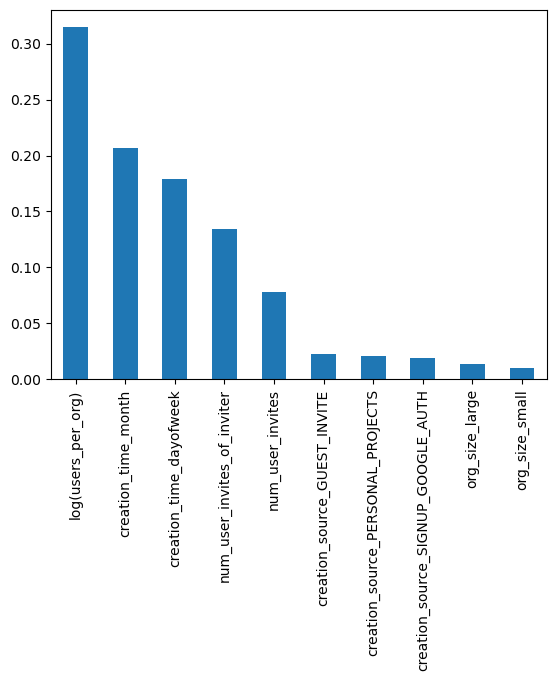

In [53]:
# precision
feature_importances = pd.Series(gridsearch_rf.best_estimator_.feature_importances_, index=columns_subset).sort_values(ascending=False)
feature_importances.plot.bar();